# Sentiment Analysis

## Recurrent Neural Network Architectures

In this notebook are the experiments and initial tests with the Recurrent Neural Network architectures to be explored, ie RNN, LSTM, GRU. The experiments were lengthy due to the big size of the data and stacked LSTM/GRU cells.

### Libraries & Dataset
Initially importing the necessary libraries.

In [ ]:
# Run this cell in case Optuna is not installed
!pip install optuna

In [1]:
# Pytorch 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim.lr_scheduler as lr_scheduler

# Nltk for tokenizer
import nltk
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

# Math, String, etc
from copy import deepcopy
import sys
import re
import os
import string
import time
import datetime
import random
import math

# Numpy, Plotting, Metrics
import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn

# Testing and metrics
import optuna
from optuna.trial import TrialState
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, classification_report
from sklearn.metrics import recall_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay

# Setting METAL to run it locally, alternatively it falls back to CUDA online or CPU as final resort
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'

Running the following only in case they're not already downloaded in your system.

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

Below is the Dataset ingestion and labeling of the classifications. I will be splitting the data into train, validation and test set, so that I can find the optimal model later on by not using the test set as control, but the validation.

In [2]:
# Using \t as delimeter and reading with pandas 
df = pd.read_csv("./imdb-reviews.csv", sep = '\t')
X = df['review']
Y = df[['rating']].copy()

# classify the ratings as positive and negative
Y.loc[Y['rating'] <= 5, 'rating'] = 0
Y.loc[Y['rating'] > 5, 'rating'] = 1

# I will reserve 8% of the samples for testing and 10% for validation to be used while tuning
train_X, val_X, test_X = X[:int(len(X)*0.82)], X[int(len(X)*0.82):int(len(X)*0.92)], X[int(len(X)*0.92):]
train_Y, val_Y, test_Y = Y[:int(len(Y)*0.82)], Y[int(len(Y)*0.82):int(len(Y)*0.92)], Y[int(len(Y)*0.92):]

# Unique returns the mapping sorted
labelsMapping, indexed_labels_train = np.unique(train_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_val = np.unique(val_Y['rating'], return_inverse=True)
labelsMapping, indexed_labels_test = np.unique(test_Y['rating'], return_inverse=True)

len(train_X), len(val_X), len(test_X), len(train_X)+len(val_X)+len(test_X)

(36906, 4501, 3601, 45008)

Defining a Dataset class to be used for the dataloaders in the general case and for Optuna.

In [3]:
# A custom Dataset class to use for the dataloaders
class customDataset(Dataset):

    def __init__(self, xdata, ydata):
        self.x = torch.tensor(xdata, dtype=torch.float)
        self.y = torch.tensor(ydata, dtype=torch.long)
        self.samples = ydata.shape[0]

    def __len__(self):
        return self.samples

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

### Tokenizer and GloVe Embeddings

Downloading the GloVe embeddings from Stanford. If you already have these you don't need to run the cell below.

In [ ]:
# Download glove embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove*.zip

In the cell below are the helper functions I wrote for preprocessing.

- In `dict_push` a GloVe file is read and each word of it is added in a dictionary with its corresponding vector.

- Since we have to work with GloVe embeddings a Stemmer that reduces words to their stems wouldn't find many matches in GloVe, so I chose to use the `LemmatizingTokenizer` class and `pos_wordnet` function I built. I simply added a final layer of removing words that are not present in the word dictionary of GloVe.

- The function `token_vectors` tokenizes a review using the Lemmatizer and adds the corresponding vectors for each word. While `prepare_data` transforms the data into these word vectors.

In [4]:
# Builds word dictionary
def dict_push(dict, file):
    with open(file, 'r') as f:
        for line in f.readlines():
            line = line.split(' ')
            # Add the vector in the dictionary
            dict[line[0]] = np.array(line[1:], dtype=float)

# Returns equivalent wordnet pos
def pos_wordnet(tag):
    if tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

# Lemmatizes using wordnet and also removes stopwords
class LemmatizingTokenizer:
    def __init__(self, word_dict) -> None:
        self.wnl = WordNetLemmatizer()
        self.word_dictionary = word_dict
    def __call__(self, review):
        tokens = nltk.word_tokenize(review)
        # make all of them lowercase
        tokens = [token.lower() for token in tokens]
         # Keep a list of the stop words from NLTK
        stopwords_list = stopwords.words('english') 
        # List of words without stopwords or punctuation
        words = []
        for token in tokens:
            if token not in stopwords_list and token not in string.punctuation:
                words.append(token)
        tokens_tagged = nltk.pos_tag(words)
        all_words = [self.wnl.lemmatize(token, pos=pos_wordnet(tag)) for token, tag in tokens_tagged]
        # Keeping only the ones that appear in Glove
        words_in_glove = [word for word in all_words if word in self.word_dictionary]
        return words_in_glove

# Tokenizes a review and adds the corresponding vectors
def token_vectors(review, word_dictionary):
    tokenizer = LemmatizingTokenizer(word_dictionary)
    tokens = tokenizer(review)
    token_vectors = []
    for token in tokens:
        token_vectors.append(word_dictionary[token])
    return np.array(token_vectors, dtype=float)

# Turns the sentences into vector embeddings
def prepare_data(X, word_dictionary):
    vectors = []
    for review in X:
        review_vector = token_vectors(review, word_dictionary)
        vectors.append(review_vector)
    return vectors

#### Network Training

I'll us the functions below to automate the training.

- The function `trainEpoch` trains a Neural Network for one epoch and calculates the loss for each batch and informs the weights. With the display boolean as true it also prints the loss with a rate of your choosing.

- Then `trainNetwork` simply trains a network till a number of epochs is reached and returns the model. Both functions take as arguments the optimizer, dataloader, loss function and device in case the GPU is used.

- The `evaluationFunction` passes the batches of the dataloader in the arguments through the model making predictions without informing the weights. It calculates and returns precision, recall and F1 macro averaged score, as well as the accuracy and mean loss.

In [5]:
# Function to train for one epoch
def trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display=True):

    losses = []

    # For each batch
    for batch, (x, y) in enumerate(dataloader):

        x = x.float()

        # In case the GPU is used
        x = x.to(device)
        y = y.to(device)
        
        # Predict and calculate loss
        prediction = neuralnetwork(x)
        loss = lossfunc(prediction, y)
        losses.append(loss.item())

        # Inform the weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # When display is set print every 64 the loss
        if(display):
            if batch % 64 == 0:
                size = len(dataloader.dataset)
                loss, current = loss.item(), batch * len(x)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


    meanloss = 0
    if len(losses)!=0:
        # The total mean loss
        meanloss = sum(losses)/len(losses)
    return meanloss
 
# Function to train a network
def trainNetwork(epochs, optimizer, dataloader, lossfunc, neuralnetwork, device, display=True):

    # For each epoch
    for epoch in range(epochs):
        if (display):
            print(f"\nEpoch {epoch+1}\n_________________________________")
        trainEpoch(optimizer, dataloader, lossfunc, neuralnetwork, device, display)
        if (display):
            print("_________________________________")
        
    # Returns the neural network
    return neuralnetwork

# Evaluation function
def evaluationFunction(dataloader, model, lossfunc, device, display=True):

    # Variable initialisation
    correctCount = 0
    sampleCount = 0
    losses = []
    preds = []
    trues = []
    probs = []

    # So the model is in eval mode
    model.eval()
    with torch.no_grad():
        
        for (x,y) in dataloader:
            x = x.float()
            x = x.to(device)
            y = y.to(device)

            # Make predictions
            scores = model(x)
            _, predictions = scores.max(1)

            # Probability estimates of the positive class
            y_probs = torch.sigmoid(scores[:,1]).cpu()
            
            # Loss
            loss = lossfunc(scores, y).item()
            losses.append(loss)

            # Saving them for the metrics later
            predictions= torch.abs(predictions.cpu())
            y=y.cpu()
            probs.extend(y_probs.numpy())
            preds.extend(predictions.numpy())
            trues.extend(y.numpy())
            correctCount += (predictions==y).sum()
            sampleCount += predictions.size(0)

    # Metric calculations
    f1macro = f1_score(y_pred=torch.tensor(preds), y_true=torch.tensor(trues), average="macro").item() * 100
    accuracy = float(correctCount) / float(sampleCount) * 100
    meanloss = sum(losses)/len(losses)
    recall = recall_score(y_true=trues, y_pred=preds) * 100
    precision = precision_score(y_true=trues, y_pred=preds) * 100

    # Printing them if display is not false
    if display:
        print("\nEvaluation Results")
        print("_________________________________")
        print(
            f"Predicted {correctCount} / {sampleCount} correctly"
            f"\nMean Loss: {meanloss:.2f} "
            f"\nRecall: {recall:.2f}%"
            f"\nPrecision: {precision:.2f}%"
            f"\nAccuracy: {accuracy:.2f}%"
            f"\nMacro Averaged F1-score: {f1macro:.2f}%"
            )
        print("_________________________________")

    # Reset the model to train mode
    model.train()

    return trues, preds, probs ,meanloss, accuracy, f1macro, recall, precision

# Confusion Matrix plotting
def confusionMatrix(trues, preds):
    names =[labelsMapping[0], labelsMapping[1]]
    cfmatr = confusion_matrix(trues, preds)
    df_cm = pd.DataFrame(cfmatr/np.sum(cfmatr) * 2, index = [i for i in names],
                     columns = [i for i in names])
    plt.figure(figsize = (9,9))
    seaborn.heatmap(df_cm, cmap='viridis_r', annot=True)
    plt.show()

# Roc Curve plotting and also returns roc auc score
def rocCurve(trues, preds, probs):
    false_positive_rate, true_positive_rate, threshold = roc_curve(trues, probs)
    roc_auc = roc_auc_score(trues, preds)
    plt.style.use('seaborn')
    plt.subplots(figsize=(8,8))
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, true_positive_rate, label="AUC="+str(roc_auc))
    plt.plot([0, 1], ls="--")
    plt.plot([0, 0], [1, 0] , c=".7") 
    plt.plot([1, 1] , c=".7")
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc='lower right')
    plt.show()

    return roc_auc

## Embeddings Vector Techniques

Since in the RNN we need the vector embeddings for each word I'll use the padding approach rather than the mean technique that performed better on a Feedforward Network. Word embeddings are trained on large datasets and capture the relationships between words so this is needed to derive context in RNNs. In terms of the Embedding layer though pytorch provides one, I chose to perform this preparation with custom functions in this particular notebook.

### Padding Approach

I define the `add_padding` function below that is keeping only a maximum length of words of each review. If it's below that threshold the rest of the vectors are padded with zeroes, so that they are of equal length.

In [6]:
# Function that padds all tokens to be equal length and return numpy array
def add_padding(X, max_length, dim):
    X_new = np.zeros(shape=(len(X), max_length, dim)).astype(float)
    for i, vector in enumerate(X):
        if vector.shape[0]<max_length:
            padding = np.zeros(shape=(max_length-vector.shape[0], dim))
            X_new[i] = np.concatenate([vector, padding])
        elif vector.shape[0]==max_length:
            X_new[i] = np.array(vector)
        else:
            X_new[i] = np.array(vector[:max_length])
    return np.array(X_new).astype(float)

Initially, I will use the 200 dimensional data from GloVe and keeping as maximum the first 30 words of each review. Since in my lemmatizing tokenizer the stopwords are removed as well as the words that are not present in the dictionary, there will be a good representation of the sentiment even in the first part of a large review.

In [7]:
# Creating the 200 dimensional dictionary
word_dictionary_200d = dict()
dict_push(word_dictionary_200d, 'glove.6B.200d.txt')

# Preparing the train validation and test data respectively
X_train = prepare_data(train_X, word_dictionary=word_dictionary_200d)
X_train_padded = add_padding(X_train, 30, 200)
X_val = prepare_data(val_X, word_dictionary=word_dictionary_200d)
X_val_padded = add_padding(X_val, 30, 200)
X_test = prepare_data(test_X, word_dictionary=word_dictionary_200d)
X_test_padded = add_padding(X_test, 30, 200)

Then I will create the datasets and corresponding Dataloaders.

In [8]:
# Datasets
trainDataset = customDataset(X_train_padded, indexed_labels_train)
valDataset = customDataset(X_val_padded, indexed_labels_val)
testDataset = customDataset(X_test_padded, indexed_labels_test)

# Corresponding dataloaders
train_dataloader = DataLoader(dataset=trainDataset, batch_size=1024, shuffle=True)
val_dataloader = DataLoader(dataset=valDataset, batch_size=1024, shuffle=True)
test_dataloader = DataLoader(dataset=testDataset, batch_size=1024, shuffle=False)

## Recurrent Neural Network

Initially I experimented with a simple RNN, using PyTorch's RNN class that applies a multi-layer Elman RNN with tanh non-linearity to an input sequence. Thus for each element in the input sequence, each layer computes the following function:

${\displaystyle {\begin{aligned}h_{t}&=\sigma _{h}(W_{h}x_{t}+U_{h}h_{t-1}+b_{h})\end{aligned}}}$

In [17]:
# Recurrent Neural Network
class RNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, layers_size, classes_size, device):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.layers_size = layers_size
        self.device = device
        self.rnn = nn.RNN(input_size, hidden_size, layers_size, batch_first=True)
        self.linear_stack = nn.Sequential(
            nn.Linear(hidden_size, classes_size),
            nn.LogSoftmax(dim=1),
        )

    def forward(self, x): 
        h_0 = torch.zeros(self.layers_size, x.size(0), self.hidden_size).to(self.device)
        output, dd = self.rnn(x, h_0)
        output = output[:, -1, :]
        return self.linear_stack(output)

Firstly, testing with two RNN layers and hidden size of 128 for twenty epochs.


Epoch 1
_________________________________
loss: 0.696225  [    0/36906]
_________________________________

Epoch 2
_________________________________
loss: 0.639376  [    0/36906]
_________________________________

Epoch 3
_________________________________
loss: 0.554554  [    0/36906]
_________________________________

Epoch 4
_________________________________
loss: 0.545201  [    0/36906]
_________________________________

Epoch 5
_________________________________
loss: 0.635460  [    0/36906]
_________________________________

Epoch 6
_________________________________
loss: 0.536467  [    0/36906]
_________________________________

Epoch 7
_________________________________
loss: 0.528530  [    0/36906]
_________________________________

Epoch 8
_________________________________
loss: 0.549369  [    0/36906]
_________________________________

Epoch 9
_________________________________
loss: 0.553486  [    0/36906]
_________________________________

Epoch 10
___________________________

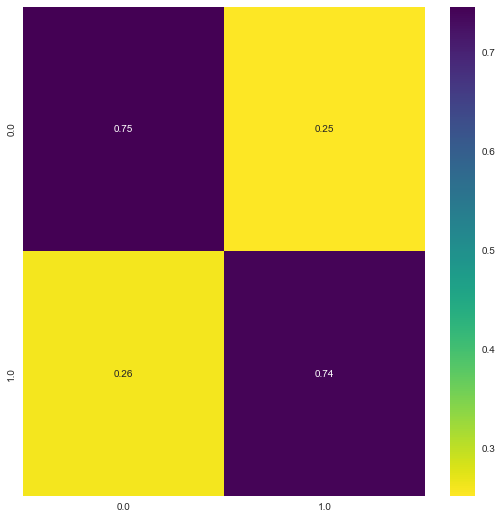

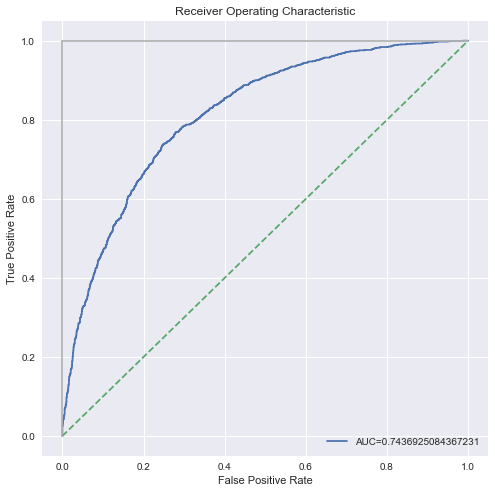

In [16]:
# Parameters
INPUT = 100
HIDDEN = 128
RNN_LAYERS = 2
CLASSES = 2

# Model initialisation and Training for 20 epochs
epochs= 20
model = RNN(input_size=INPUT, hidden_size=HIDDEN, layers_size=RNN_LAYERS, classes_size=CLASSES, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0003)
lossfunc = nn.CrossEntropyLoss()
model = trainNetwork(epochs, optimizer, train_dataloader, lossfunc, model, device)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

As an initial test it didn't do too badly without any finetuning and only using the vanilla RNN. Now, I'll increase the words that are used as well as the dimensions before moving in to the more advanced cells.

In [7]:
# Creating the 300 dimensional dictionary
word_dictionary_300d = dict()
dict_push(word_dictionary_300d, 'glove.6B.300d.txt')

# Preparing the train validation and test data respectively
X_train = prepare_data(train_X, word_dictionary=word_dictionary_300d)
X_train_padded = add_padding(X_train, 45, 300)
X_val = prepare_data(val_X, word_dictionary=word_dictionary_300d)
X_val_padded = add_padding(X_val, 45, 300)
X_test = prepare_data(test_X, word_dictionary=word_dictionary_300d)
X_test_padded = add_padding(X_test, 45, 300)

Then again creating the dataloaders with a batch_size of 512.

In [8]:
# Datasets
trainDataset = customDataset(X_train_padded, indexed_labels_train)
valDataset = customDataset(X_val_padded, indexed_labels_val)
testDataset = customDataset(X_test_padded, indexed_labels_test)

# Corresponding dataloaders
train_dataloader = DataLoader(dataset=trainDataset, batch_size=512, shuffle=True)
val_dataloader = DataLoader(dataset=valDataset, batch_size=512, shuffle=True)
test_dataloader = DataLoader(dataset=testDataset, batch_size=512, shuffle=False)

### Long Short-Term Memory 

For the initial test I'll be using one LSTM layer again using Pytorch's LSTM class where for each element in the input sequence, each layer computes the following function: 

${\displaystyle {\begin{aligned}f_{t}&=\sigma _{g}(W_{f}x_{t}+U_{f}h_{t-1}+b_{f})\\i_{t}&=\sigma _{g}(W_{i}x_{t}+U_{i}h_{t-1}+b_{i})\\o_{t}&=\sigma _{g}(W_{o}x_{t}+U_{o}h_{t-1}+b_{o})\\{\tilde {c}}_{t}&=\sigma _{c}(W_{c}x_{t}+U_{c}h_{t-1}+b_{c})\\c_{t}&=f_{t}\odot c_{t-1}+i_{t}\odot {\tilde {c}}_{t}\\h_{t}&=o_{t}\odot \sigma _{h}(c_{t})\end{aligned}}}$

In [20]:
# LSTM Neural Network
class LSTM(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        packed_output, (hidden, cell) = self.lstm(x)
        return self.linear(packed_output[:, -1, :])

Then training this LSTM network for five epochs with hidden dimension of 264.


Epoch 1
_________________________________
loss: 0.694252  [    0/36906]
loss: 0.463158  [32768/36906]
_________________________________

Epoch 2
_________________________________
loss: 0.422455  [    0/36906]
loss: 0.429864  [32768/36906]
_________________________________

Epoch 3
_________________________________
loss: 0.391862  [    0/36906]
loss: 0.511263  [32768/36906]
_________________________________

Epoch 4
_________________________________
loss: 0.360592  [    0/36906]
loss: 0.426041  [32768/36906]
_________________________________

Epoch 5
_________________________________
loss: 0.344273  [    0/36906]
loss: 0.391564  [32768/36906]
_________________________________

Evaluation Results
_________________________________
Predicted 2814 / 3601 correctly
Mean Loss: 0.45 
Recall: 78.84%
Precision: 77.84%
Accuracy: 78.14%
Macro Averaged F1-score: 78.14%
_________________________________


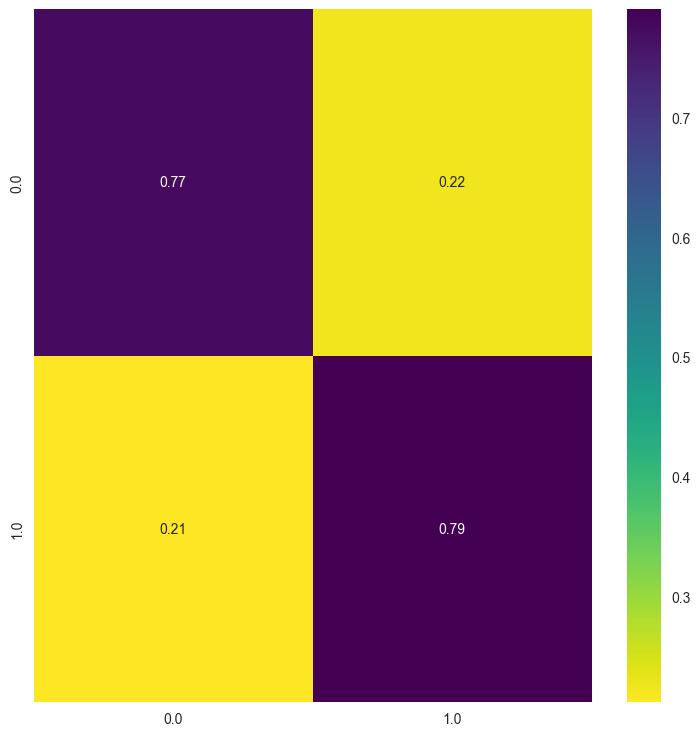

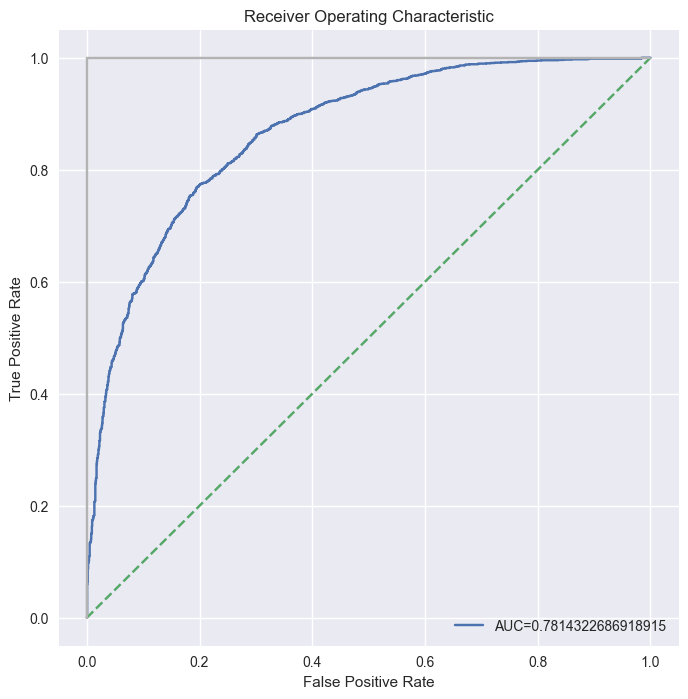

In [22]:
# Parameters
INPUT = 300
HIDDEN = 264
CLASSES = 2

# Model initialisation and Training for 10 epochs
epochs= 5
learning_rate = 3e-2 
model = LSTM(INPUT, 300, HIDDEN, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lossfunc = nn.CrossEntropyLoss()
model = trainNetwork(epochs, optimizer, train_dataloader, lossfunc, model, device, display=True)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

The LSTM did much better than the RNN, but it still fell short of the feed forward networks. Even though it is early to draw conclusions before finetuning this model, the suspicion I have is that is due to the zero values of the padding and the words that are "chopped off" so I will explore this further.

### Investigating Word Length

I'll examine below the length of the review to see if with that length I provided we get adequate information to cover the average length of the reviews.

In [25]:
def count_length_avg(X):
    count = 0
    total = 0
    for i, vector in enumerate(X):
        total += vector.shape[0]
        count +=1
    return float(total/count)

maxim = count_length_avg(X_train)

print("Average length of words in a review is: ", maxim )

Average length of words in a review is:  127.36647157643743


This shows me that I will need to approach this problem differently when it comes to the padding since some reviews are obviously chopped off, but keeping the longer ones will end up to a lot of zeroes which will affect the LSTM's performance as well. But before fixing that I will trial the other architectures as well with this current padding approach. So below I'll initially try a bidirectional LSTM.

In [30]:
# Bidirectional Recurrent Neural Network
class BRNN(nn.Module):
    
    def __init__(self, input_size, hidden_size, classes_size, device):
        super(BRNN, self).__init__()
        self.hidden_size = hidden_size
        self.device = device
        self.brnn = nn.LSTM(input_size, hidden_size, batch_first=True, bidirectional=True)
        self.linear_stack = nn.Sequential(
            nn.Linear(hidden_size*2, classes_size),
        )

    def forward(self, x): 
        output, _ = self.brnn(x)
        output = output[:, -1, :]
        return self.linear_stack(output)

Testing the bidirectional LSTM with a hidden size of 130 for 10 epochs.


Epoch 1
_________________________________
loss: 0.691758  [    0/36906]
loss: 0.574885  [32768/36906]
_________________________________

Epoch 2
_________________________________
loss: 0.509514  [    0/36906]
loss: 0.429907  [32768/36906]
_________________________________

Epoch 3
_________________________________
loss: 0.396938  [    0/36906]
loss: 0.440396  [32768/36906]
_________________________________

Epoch 4
_________________________________
loss: 0.399275  [    0/36906]
loss: 0.409137  [32768/36906]
_________________________________

Epoch 5
_________________________________
loss: 0.392206  [    0/36906]
loss: 0.317401  [32768/36906]
_________________________________

Epoch 6
_________________________________
loss: 0.305431  [    0/36906]
loss: 0.354402  [32768/36906]
_________________________________

Epoch 7
_________________________________
loss: 0.291045  [    0/36906]
loss: 0.324303  [32768/36906]
_________________________________

Epoch 8
________________________________

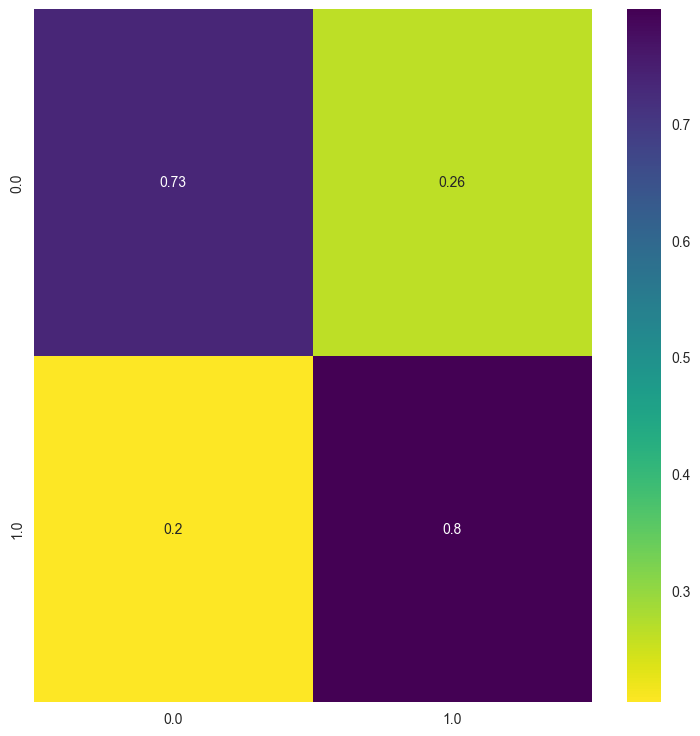

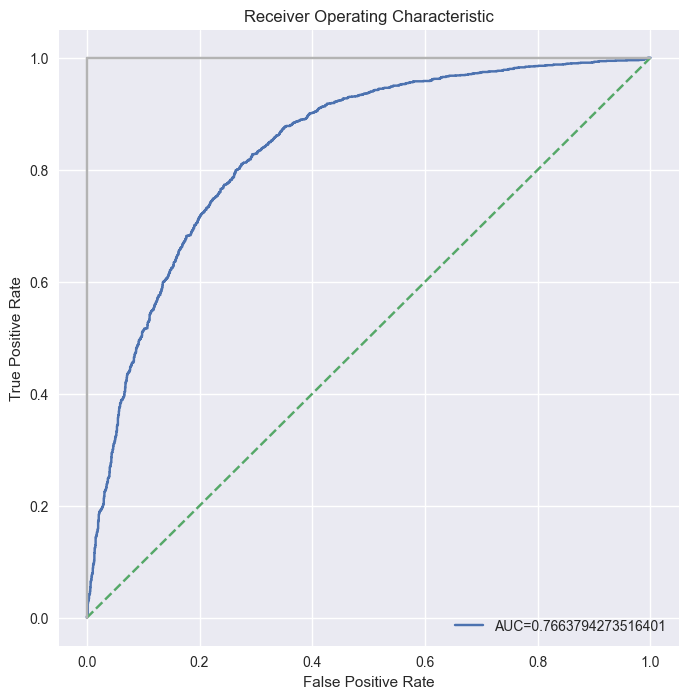

In [32]:
# Parameters
INPUT = 300
HIDDEN = 130
RNN_LAYERS = 2
CLASSES = 2

# Model initialisation and Training for 10 epochs
epochs=10
learning_rate = 3e-2 
model = BRNN(input_size=INPUT, hidden_size=HIDDEN, classes_size=CLASSES, device=device).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lossfunc = nn.CrossEntropyLoss()
model = trainNetwork(epochs, optimizer, train_dataloader, lossfunc, model, device)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Interestingly the bidirectional version performed worse. I will then define a bidirectional LSTM with two layers below.

In [33]:
# Recurrent Neural Network
class BRNN_02(nn.Module):
    
    def __init__(self, input_size, hidden_size, classes_size, device):
        super(BRNN_02, self).__init__()
        self.hidden_size = hidden_size
        self.device = device
        self.brnn = nn.LSTM(input_size, hidden_size, 2, batch_first=True, bidirectional=True)
        self.linear_stack = nn.Sequential(
            nn.Linear(hidden_size*2, classes_size),
        )

    def forward(self, x): 
        output, _ = self.brnn(x)
        output = output[:, -1, :]
        return self.linear_stack(output)

And test this stacked LSTM bidirectional with a hidden size of 300 for five epochs.


Epoch 1
_________________________________
loss: 0.692891  [    0/36906]
loss: 0.712571  [32768/36906]
_________________________________

Epoch 2
_________________________________
loss: 0.725855  [    0/36906]
loss: 0.709117  [32768/36906]
_________________________________

Epoch 3
_________________________________
loss: 0.558248  [    0/36906]
loss: 0.485782  [32768/36906]
_________________________________

Epoch 4
_________________________________
loss: 0.458885  [    0/36906]
loss: 0.540391  [32768/36906]
_________________________________

Epoch 5
_________________________________
loss: 0.454132  [    0/36906]
loss: 0.427707  [32768/36906]
_________________________________

Evaluation Results
_________________________________
Predicted 2715 / 3601 correctly
Mean Loss: 0.51 
Recall: 88.31%
Precision: 70.25%
Accuracy: 75.40%
Macro Averaged F1-score: 74.96%
_________________________________


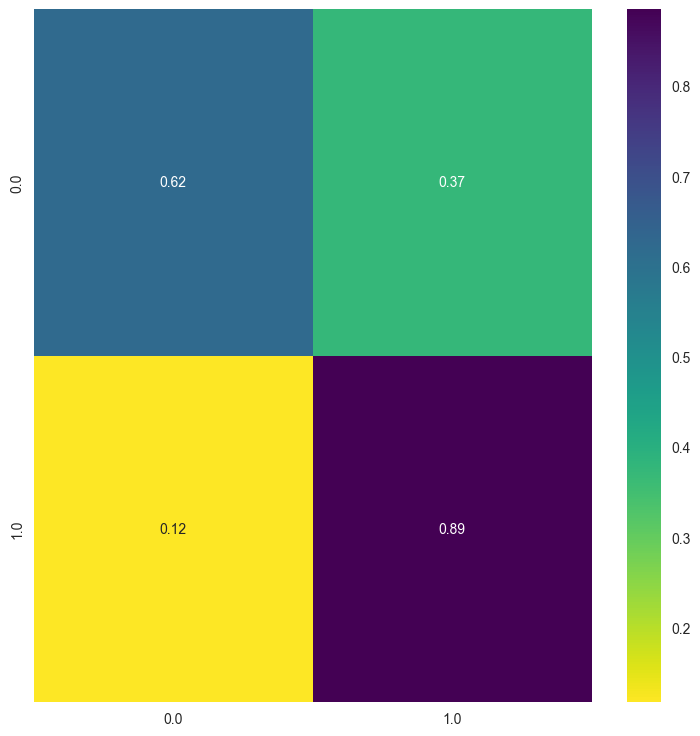

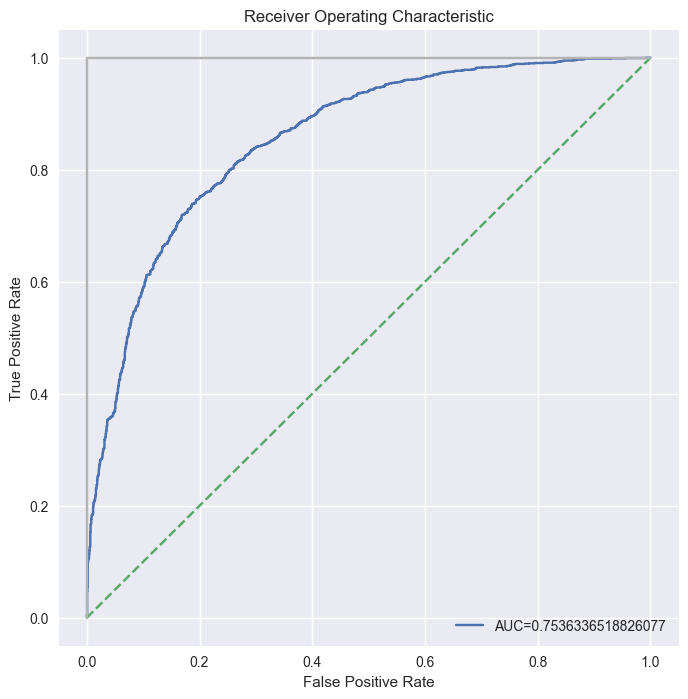

In [34]:
# Parameters
INPUT = 300
HIDDEN = 300
CLASSES = 2

# Model initialisation and Training for 10 epochs
epochs=5
learning_rate = 3e-2 
model = BRNN_02(input_size=INPUT, hidden_size=HIDDEN, classes_size=CLASSES, device=device).to(device)
optimizer = torch.optim.Adagrad(model.parameters(), lr=learning_rate)
lossfunc = nn.CrossEntropyLoss()
model = trainNetwork(epochs, optimizer, train_dataloader, lossfunc, model, device)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

Interestingly, this performed even worse, but this might also be due to the increased hidden size and the extra LSTM layer. In any case the fact that it is always around 75% gives me an idea of the performance with this particular approach.

### Gated Recurrent Unit

Finally, I will define a simple GRU network using again Pytorch's class with one layer that computes the following function:

${\displaystyle {\begin{aligned}z_{t}&=\sigma _{g}(W_{z}x_{t}+U_{z}h_{t-1}+b_{z})\\r_{t}&=\sigma _{g}(W_{r}x_{t}+U_{r}h_{t-1}+b_{r})\\{\hat {h}}_{t}&=\phi _{h}(W_{h}x_{t}+U_{h}(r_{t}\odot h_{t-1})+b_{h})\\h_{t}&=z_{t}\odot h_{t-1}+(1-z_{t})\odot {\hat {h}}_{t}\end{aligned}}}$

In [35]:
# Recurrent Neural Network
class GRU_01(nn.Module):
    
    def __init__(self, input_size, hidden_size, classes_size, device):
        super(GRU_01, self).__init__()
        self.hidden_size = hidden_size
        self.device = device
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.linear_stack = nn.Sequential(
            nn.Linear(hidden_size, classes_size),
        )

    def forward(self, x): 
        output, _ = self.gru(x)
        output = output[:, -1, :]
        return self.linear_stack(output)

Then, I will train this network for three epochs using a hidden size of 264.


Epoch 1
_________________________________
loss: 5.570699  [    0/36906]
loss: 0.593488  [32768/36906]
_________________________________

Epoch 2
_________________________________
loss: 0.589865  [    0/36906]
loss: 0.490629  [32768/36906]
_________________________________

Epoch 3
_________________________________
loss: 0.411412  [    0/36906]
loss: 0.406604  [32768/36906]
_________________________________

Evaluation Results
_________________________________
Predicted 2783 / 3601 correctly
Mean Loss: 0.46 
Recall: 81.27%
Precision: 75.35%
Accuracy: 77.28%
Macro Averaged F1-score: 77.24%
_________________________________


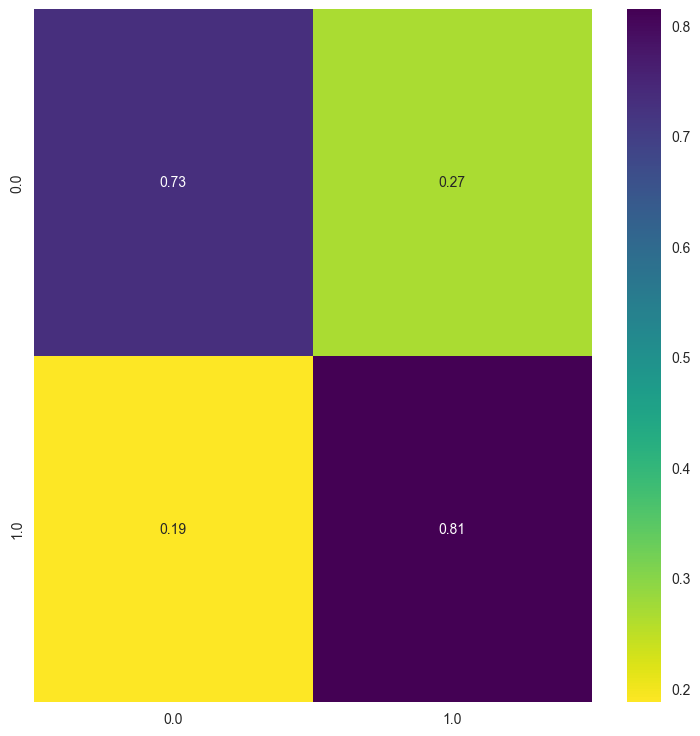

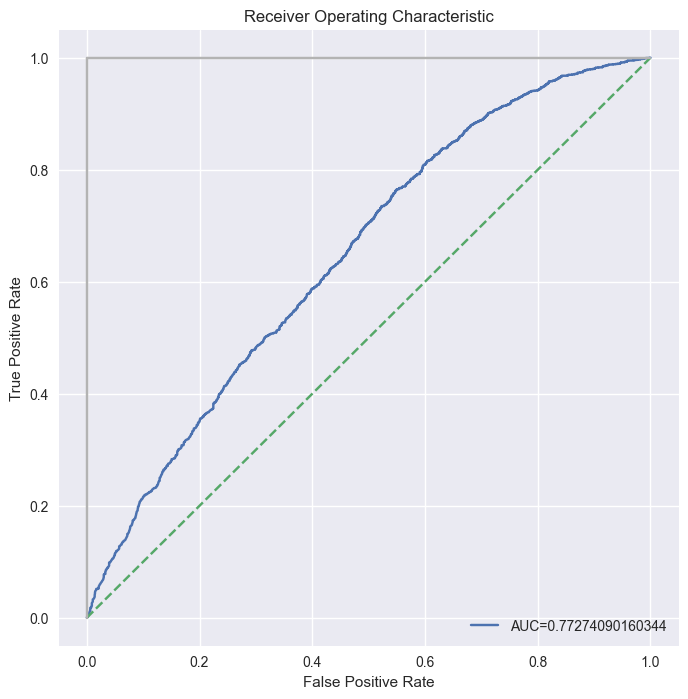

In [36]:
# Parameters
INPUT = 300
HIDDEN = 264
CLASSES = 2

# Model initialisation and Training for 10 epochs
epochs= 3
learning_rate = 3e-2 
model = GRU_01(INPUT, 300, HIDDEN, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lossfunc = nn.CrossEntropyLoss()
model = trainNetwork(epochs, optimizer, train_dataloader, lossfunc, model, device, display=True)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)
confusionMatrix(trues, preds)
roc_auc = rocCurve(trues, preds, probs)

This network performed similarly to the LSTM in a much shorter time, which is to be expected, but still well below the 80%. Now before enhancing the network further I will do a final attempt to see if we can find any better parameters with optuna for the learning rate as well as the hidden state in its current naive form.

#### Optuna Tuning

In [37]:
# The initial constants
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'
DEVICE = torch.device(device=device)
BATCHSIZE = 512
CLASSES = 2
EPOCHS = 4

def objective(trial):

    # Parameters constant
    INPUT = 300
    CLASSES = 2

    # Tune with optuna
    hidden_size = trial.suggest_int("hidden_size", 4, 800)

    model = GRU_01(input_size=INPUT, hidden_size=hidden_size, classes_size=CLASSES, device=device).to(device)

    lr = trial.suggest_float("lr", 1e-6, 1e-1, log=True)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    lossfunc = nn.CrossEntropyLoss()

    # Training of the model
    for epoch in range(EPOCHS):

        meanloss = trainEpoch(optimizer, train_dataloader, lossfunc, model, device, display=False)
        trial.report(meanloss, epoch)

        # Handle pruning based on the intermediate value.
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return meanloss


if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")

    study.optimize(objective, n_trials=20, timeout=2000)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print("Study statistics: ")
    print("  Number of finished trials: ", len(study.trials))
    print("  Number of pruned trials: ", len(pruned_trials))
    print("  Number of complete trials: ", len(complete_trials))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: ", trial.value)

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value)) 

[I 2022-12-20 10:42:00,412] A new study created in memory with name: no-name-039aca99-da42-4a91-980d-f3fed875cb19
[I 2022-12-20 10:45:31,247] Trial 0 finished with value: 0.41748486520492867 and parameters: {'hidden_size': 301, 'lr': 0.0021052460027657545}. Best is trial 0 with value: 0.41748486520492867.
[I 2022-12-20 10:47:20,276] Trial 1 finished with value: 0.36159823528707846 and parameters: {'hidden_size': 113, 'lr': 0.020285367903026104}. Best is trial 1 with value: 0.36159823528707846.
[I 2022-12-20 10:49:00,378] Trial 2 finished with value: 0.3598913962710394 and parameters: {'hidden_size': 98, 'lr': 0.005679733333980422}. Best is trial 2 with value: 0.3598913962710394.
[I 2022-12-20 10:49:33,468] Trial 3 finished with value: 0.3623221990180342 and parameters: {'hidden_size': 29, 'lr': 0.0011060983940500266}. Best is trial 2 with value: 0.3598913962710394.
[I 2022-12-20 10:54:15,834] Trial 4 finished with value: 0.7025922928770928 and parameters: {'hidden_size': 442, 'lr': 7.9

Study statistics: 
  Number of finished trials:  20
  Number of pruned trials:  14
  Number of complete trials:  6
Best trial:
  Value:  0.3573487315275898
  Params: 
    hidden_size: 39
    lr: 4.306314147746954e-05


After finding the optimal hidden size and learning rate, I define the optimalModel function to save the model with the best performance as suggested in the lab. This function will be useful later on as well.

In [38]:
# Function automating finding best model
def optimalModel(device, model, epochs, traindataloader, valdataloader, optimizer, lossfunc, display=False, scheduler=None):

    # Variable initialisation
    bestf1=0
    bestepoch=0
    trainlosses = []
    validlosses = []
    average = 0
    
    # For each epoch
    for epoch in range(epochs):

        if (display):
            print(f"Epoch {epoch+1}\n__________________________________")
        
        # Train the model
        meanLoss = trainEpoch(optimizer, traindataloader, lossfunc,  model, device, display)

        # Evaluation
        _, _, _, meanlossval, accura, macrof1, recall, precision = evaluationFunction(valdataloader, model, lossfunc, device, display)

        if (display):
            print("Training loss: ", meanLoss , " validation loss: ", meanlossval, " and accuracy: ", accura)
    
        trainlosses.append(meanLoss)
        validlosses.append(meanlossval)
        average += abs(meanLoss-meanlossval)
        
        # If f1 score is better
        if (bestf1<macrof1):
            bestepoch=epoch
            bestf1=macrof1

            # Save the model
            torch.save(model.state_dict(), './bestModel.pt')
            torch.save(optimizer.state_dict(), './bestOptimizer.pt')
            if(scheduler):
                torch.save(scheduler.state_dict(), './bestScheduler.pt')
    
        if(display):
            print("__________________________________")
        
        # If there is a scheduler step here
        if (scheduler):
            if (scheduler.__class__.__name__=='ReduceLROnPlateau'):
                scheduler.step(meanloss)
            else:
                scheduler.step()

    print("Training loss - validation loss average difference: ", abs(average/len(trainlosses)))

    x = list(range(0, len(trainlosses)))
    plt.style.use('seaborn')
    plt.plot(x, trainlosses, linestyle="-", label="Training")
    plt.plot(x, validlosses, linestyle="-", label="Validation")
    plt.legend()
    plt.show()

    return bestepoch

Then testing with the parameters found above for 14 epochs

Training loss - validation loss average difference:  0.09030255709984789


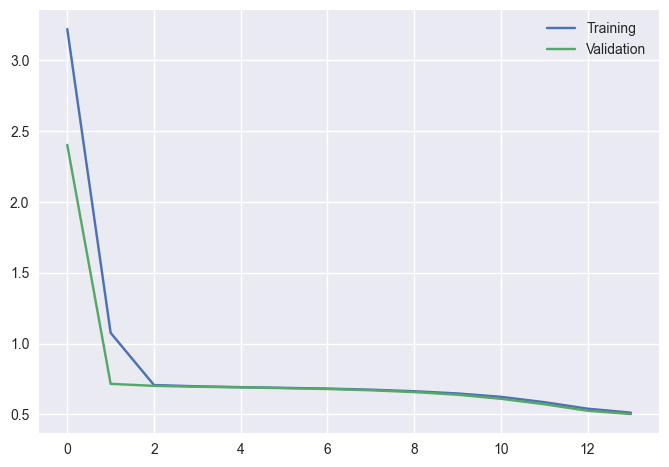

Best F1 score after  13  epochs.

Evaluation Results
_________________________________
Predicted 2743 / 3601 correctly
Mean Loss: 0.51 
Recall: 77.51%
Precision: 75.58%
Accuracy: 76.17%
Macro Averaged F1-score: 76.17%
_________________________________


In [39]:
# Setting Metal to run it locally alternatively it falls back to Cuda or cpu online
device = 'mps' if (torch.backends.mps.is_available()) else 'cuda' if ( torch.cuda.is_available()) else 'cpu'

# Hyperparameters
epochs= 14
learning_rate = 4.306314147746954e-05
dataloader= train_dataloader

# Model initialisation and Training here 1 since it's only one vector and 300 dimension
model = GRU_01(INPUT, 300, 39, 2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lossfunc = nn.CrossEntropyLoss()
best_epoch = optimalModel(device, model, epochs, dataloader, val_dataloader, optimizer, lossfunc)

print("Best F1 score after ", best_epoch, " epochs.")

# Initialise and load the model with the best performance
model = GRU_01(INPUT, 300, 39, 2).to(device)
model.load_state_dict(torch.load('./bestModel.pt'))
model = model.to(device)

# Evaluate on the test set and print confusion matrix and roc curve
trues, preds, probs, meanloss, acura, f1, recall, precision = evaluationFunction(test_dataloader, model, lossfunc, device)

So even with the best parameters found with Optuna it doesn't perform better than the LSTM. But the good thing is that the model isn't overfitting. In the following notebooks I will explore how to solve the padding problem and enhancing the RNNs with more layers, hyperparameter tuning, gradient clipping, skip connections, dropout probability, as well as attention.